In [1]:
import numpy as np 
import pandas as pd

import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Raw data
train = pd.read_csv('./archive/train.csv')
test = pd.read_csv('./archive/test.csv')
test['Target'] = np.nan

data = train.append(test, sort = True)

In [3]:
# Some households will not have the houseleader with a target variable
# disregard those, mark them as 4 by default
train_valid = train.loc[train['parentesco1'] == 1, ['idhogar', 'Id', 'Target']].copy()
test_valid = test.loc[test['parentesco1'] == 1, ['idhogar', 'Id']].copy()

submission_base = test[['Id', 'idhogar']]

In [4]:
def get_similar_cols(data, groupby_format):
    """Returns columns that follow a similar groupby_format"""
    return data.filter(like=groupby_format, axis=1).columns.tolist()

def get_corrs_matrix(data, corr_threshold=0.95):
    """ Returns a list: correlation matrix, columns to drop based on the correlation threshold"""
    corr_matrix = data.corr()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [c for c in upper.columns if any(abs(upper[c]) > corr_threshold)]
    return [corr_matrix, to_drop]

def get_dtypes(data, verbose=False):
    """Returns a list: numerical values, object-like columns"""
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics_cols = data.select_dtypes(include=numerics).columns
    object_cols = data.select_dtypes(include='object').columns
    if verbose:
        print('There are {0} numeric cols: {1}\nThere are {2} object cols: {3}\nThere are total cols: {4}'.format
              (len(numerics_cols),numerics_cols, len(object_cols), object_cols, len(data.columns)))
    return [numerics_cols, object_cols]

def get_missing_values(data, cols):
    """Returns a dataframe with missing values (in absolute and percentage format)"""
    
    missing_percent = data[cols].apply(lambda x: sum(x.isnull())/len(x), axis=0).sort_values(ascending=False)
    missing_abs = data[cols].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)
    df = pd.DataFrame({'Missing': missing_abs, 'Percent': missing_percent})
    
    # Removing zero values
    df = df.loc[~(df==0).all(axis=1)]
    return df

## Analyze: dtypes

In [5]:
data.select_dtypes('object').columns

Index(['Id', 'dependency', 'edjefa', 'edjefe', 'idhogar'], dtype='object')

In [6]:
# Reshaping the mixed values for object
mapping_incorrections = {'yes': 1, 'no': 0}

# Reshaping the data based on replace the yes and no
for col in ['dependency', 'edjefa', 'edjefe']:
    data[col] = data[col].replace(mapping_incorrections).astype(np.float64)
    
data[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,33413.000000,33413.000000,33413.000000
mean,1.172238,2.827822,5.170353
std,1.649249,4.606153,5.214174
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


## Missing Values

In [7]:
get_missing_values(data, data.columns)

,Missing,Percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
Target,23856,0.713974
SQBmeaned,36,0.001077
meaneduc,36,0.001077


In [8]:
# Filling in the missing value
data['v18q1'] = data['v18q1'].fillna(0)

# Updating the payment to 0 for people who own the property
data.loc[(data['v2a1'].isnull()) & (data['tipovivi1'] == 1), "v2a1"] = 0

# Creating an additional boolean values of people who have missing values
data['v2a1-missing'] = data['v2a1'].isnull()

# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

# Fixing an outlier
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

## Analyze: Columns Type

In [9]:
# tamviv: The # of people living in the house, hhsize: The # of people in the household
# Thus, the difference could provide some insight
data['hhsize-diff'] = data['tamviv'] - data['hhsize']

# Correlated Values: coopele
elec = []

# Assign values for electricity (ordinal values)
for i, row in data.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
data['elec'] = elec
data['elec-missing'] = data['elec'].isnull()

# Wall Ordinal Variables
walls_columns = get_similar_cols(data, groupby_format='epared')
data['walls'] = np.argmax(np.array(data[walls_columns]), axis=1)

# Roof Ordinal Variables
roof_columns = get_similar_cols(data, groupby_format='etecho')
data['roof'] = np.argmax(np.array(data[roof_columns]), axis=1)

# Floor Ordinal Variables
floor_columns = get_similar_cols(data, groupby_format='eviv')
data['floor'] = np.argmax(np.array(data[floor_columns]), axis=1)

# Per capita features
data['phones-per-capita'] = data['qmobilephone'] / data['tamviv']
data['tablets-per-capita'] = data['v18q1'] / data['tamviv']
data['rooms-per-capita'] = data['rooms'] / data['tamviv']
data['rent-per-capita'] = data['v2a1'] / data['tamviv']

# No toilet, no electricity, no floor, no water service, no ceiling
data['warning'] = 1 * (data['sanitario1'] + (data['elec'] == 0) + 
                        data['pisonotiene'] + data['abastaguano'] + 
                        (data['cielorazo'] == 0))

# Owns a refrigerator, computer, tablet, and television
data['bonus'] = 1 * (data['refrig'] + 
                     data['computer'] + 
                     (data['v18q1'] > 0) + 
                     data['television'])

# Create one feature from the `instlevel` columns
instl_vars = get_similar_cols(data, 'instl')
data['instl_var'] = np.argmax(np.array(data[[c for c in instl_vars]]), axis=1)

data['escolari/age'] = data['escolari'] / data['age']
data['instl_var/age'] = data['instl_var'] / data['age']
data['tech'] = data['v18q'] + data['mobilephone']

data.shape

(33413, 161)

## Removing Columns

### Removing Squared Columns

In [10]:
data = data[[x for x in data if not x.startswith('SQB')]]
data = data.drop(columns = ['agesq'])
data.shape

(33413, 152)

## Removing Correlated Columns

In [11]:
corr_matrix, to_drop = get_corrs_matrix(data)
to_drop

['area2',
 'hogar_total',
 'male',
 'public',
 'r4t3',
 'tamhog',
 'elec',
 'instl_var']

In [12]:
# Dropping the columns
data.drop(to_drop, axis=1, inplace=True)
data.shape

(33413, 144)

## Establish Correct Variable Types


We need to specify the correct variables types:

- Individual Variables: these are characteristics of each individual rather than the household
    - Boolean: Yes or No (0 or 1)
    - Ordered Discrete: Integers with an ordering
- Household variables
    - Boolean: Yes or No
    - Ordered Discrete: Integers with an ordering
- Continuous numeric
    - Below we manually define the variables in each category. This is a little tedious, but also necessary.

In [13]:
import featuretools.variable_types as vtypes


In [14]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing', 'elec-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin','hhsize-diff',
              'elec',  'walls', 'roof', 'floor', 'walls+roof+floor', 'warning', 'bonus',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding',
          'phones-per-capita', 'tablets-per-capita', 'rooms-per-capita', 'rent-per-capita']

In [15]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['age', 'escolari', 'rez_esc', 'inst', 'tech']

ind_cont = ['escolari/age', 'inst/age']

In [16]:
# Any values we have not consider?
to_remove = []
for l in [hh_ordered, hh_bool, hh_cont, ind_bool, ind_ordered, ind_cont]:
    for c in l:
        if c not in data:
            to_remove.append(c)
            
for l in [hh_ordered, hh_bool, hh_cont, ind_bool, ind_ordered, ind_cont]:
    for c in to_remove:
        if c in l:
            l.remove(c)

In [17]:
# Converting to boolean
for variable in (hh_bool + ind_bool):
    data[variable] = data[variable].astype('bool')

In [18]:
# Converting to float
for variable in (hh_cont + ind_cont):
    data[variable] = data[variable].astype(float)

In [19]:
# Converting to int
for variable in (hh_ordered + ind_ordered):
    try:
        data[variable] = data[variable].astype(int)
    except Exception as e:
        print(f'Could not convert {variable} because of missing values.')

Could not convert rez_esc because of missing values.


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

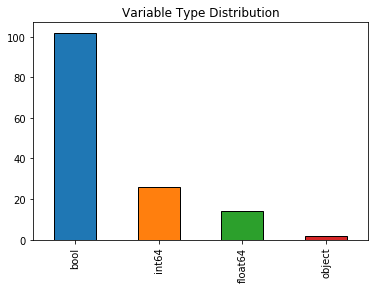

In [21]:
data.dtypes.value_counts().plot.bar(edgecolor = 'k');
plt.title('Variable Type Distribution');


## EntitySet and Entities


In [22]:
es = ft.EntitySet(id = 'households')
es.entity_from_dataframe(entity_id = 'data', 
                         dataframe = data, 
                         index = 'Id')

Entityset: households
  Entities:
    data [Rows: 33413, Columns: 144]
  Relationships:
    No relationships

### Normalize Household Table
- Normalization allows us to create another table with one unique row per instance. In this case, the instances are households. 
- The new table is derived from the data table and we need to bring along any of the household level variables. 
- Since these are the same for all members of a household, we can directly add these as columns in the household table using additional_variables. The index of the household table is idhogar which uniquely identifies each household.

In [23]:
es.normalize_entity(base_entity_id='data', 
                    new_entity_id='household', 
                    index='idhogar', 
                    additional_variables=hh_bool + hh_ordered + hh_cont + ['Target'])
es

Entityset: households
  Entities:
    data [Rows: 33413, Columns: 41]
    household [Rows: 10340, Columns: 104]
  Relationships:
    data.idhogar -> household.idhogar

Note:
- Table Relationships
    - Normalizing the entity automatically adds in the relationship between the parent, household, and the child, ind. This relationship links the two tables and allows us to create "deep features" by aggregating individuals in each household.

## Deep Feature Synthesis
- Using feature primitives, Deep Feature Synthesis can build hundreds (or 1000s as we will later see) of features from the relationships between tables and the columns in tables themselves. There are two types of primitives, which are operations applied to data:
    - Aggregation primitives: These primitives take related instances as an input and output a single value. They are applied across a parent-child relationship in an entity set. E.g: `"count"`, `"sum"`, `"avg_time_between"`.
    - Transform primitives: These primitives take one or more variables from an entity as an input and output a new variable for that entity. They are applied to a single entity. E.g: `"hour"`, `"time_since_previous"`, `"absolute"`

In [25]:
# Deep Feature Synthesis
# Aggregation and Transform primitives are build as default
feature_matrix, feature_names = ft.dfs(entityset=es, 
                                       target_entity = 'household', 
                                       max_depth = 2, 
                                       verbose = 1, 
                                       n_jobs = -1, 
                                       chunk_size = 100)

Built 173 features
EntitySet scattered to workers in 2.594 seconds
Elapsed: 01:09 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 104/104 chunks


In [26]:
all_features = [str(x.get_name()) for x in feature_names]
feature_matrix.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,PERCENT_TRUE(data.parentesco2),PERCENT_TRUE(data.parentesco3),PERCENT_TRUE(data.parentesco4),PERCENT_TRUE(data.parentesco5),PERCENT_TRUE(data.parentesco6),PERCENT_TRUE(data.parentesco7),PERCENT_TRUE(data.parentesco8),PERCENT_TRUE(data.parentesco9),PERCENT_TRUE(data.v18q),PERCENT_TRUE(data.rez_esc-missing)
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,False,False,True,True,True,False,False,False,False,False,...,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00
000bce7c4,False,False,True,True,False,True,False,False,False,False,...,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
001845fb0,False,False,True,True,True,False,False,False,False,False,...,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25
001ff74ca,False,False,True,True,True,False,False,False,False,False,...,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00
003123ec2,False,False,True,True,False,False,True,True,False,False,...,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [27]:
# We need to remove any columns containing derivations of the Target. 
# These are created because some of transform primitives might have affected the Target.

drop_cols = []
for col in feature_matrix:
    if col == 'Target':
        pass
    else:
        if 'Target' in col:
            drop_cols.append(col)
            
print(drop_cols)            
feature_matrix = feature_matrix[[x for x in feature_matrix if x not in drop_cols]]         
feature_matrix.head()

[]


,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,PERCENT_TRUE(data.parentesco2),PERCENT_TRUE(data.parentesco3),PERCENT_TRUE(data.parentesco4),PERCENT_TRUE(data.parentesco5),PERCENT_TRUE(data.parentesco6),PERCENT_TRUE(data.parentesco7),PERCENT_TRUE(data.parentesco8),PERCENT_TRUE(data.parentesco9),PERCENT_TRUE(data.v18q),PERCENT_TRUE(data.rez_esc-missing)
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,False,False,True,True,True,False,False,False,False,False,...,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00
000bce7c4,False,False,True,True,False,True,False,False,False,False,...,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
001845fb0,False,False,True,True,True,False,False,False,False,False,...,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25
001ff74ca,False,False,True,True,True,False,False,False,False,False,...,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00
003123ec2,False,False,True,True,False,False,True,True,False,False,...,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [28]:
feature_matrix.shape

(10340, 173)

## Feature Selection

In [26]:
# We can do some rudimentary feature selection, 
# removing one of any pair of columns with a correlation greater than 0.99 (absolute value).

corr_matrix, to_drop = get_corrs_matrix(feature_matrix, corr_threshold=.99)
to_drop

['MIN(data.tech)', 'MEAN(data.tech)', 'COUNT(data)']

In [29]:
feature_matrix = feature_matrix[[x for x in feature_matrix if x not in to_drop]]

## Training/Testing Sets

In [30]:
train = feature_matrix[feature_matrix['Target'].notnull()].reset_index()
test = feature_matrix[feature_matrix['Target'].isnull()].reset_index()
train.head()

,idhogar,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,...,PERCENT_TRUE(data.parentesco2),PERCENT_TRUE(data.parentesco3),PERCENT_TRUE(data.parentesco4),PERCENT_TRUE(data.parentesco5),PERCENT_TRUE(data.parentesco6),PERCENT_TRUE(data.parentesco7),PERCENT_TRUE(data.parentesco8),PERCENT_TRUE(data.parentesco9),PERCENT_TRUE(data.v18q),PERCENT_TRUE(data.rez_esc-missing)
0,001ff74ca,False,False,True,True,True,False,False,False,False,...,0.00,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,003123ec2,False,False,True,True,False,False,True,True,False,...,0.25,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,004616164,False,False,True,True,False,False,False,False,False,...,0.00,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,004983866,False,False,True,True,False,False,False,True,False,...,0.00,0.000000,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
4,005905417,False,False,True,False,False,True,False,False,False,...,0.00,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Analysis: Target

### Correlation with Target

In [31]:
corrs = train.corr()
corrs['Target'].sort_values(ascending = True).head(10)

warning                           -0.300071
hogar_nin                         -0.268105
r4t1                              -0.256750
PERCENT_TRUE(data.instlevel1)     -0.249333
PERCENT_TRUE(data.instlevel2)     -0.245484
overcrowding                      -0.238148
PERCENT_TRUE(data.estadocivil1)   -0.215546
eviv1                             -0.215123
epared1                           -0.212209
pisocemento                       -0.209285
Name: Target, dtype: float64

In [32]:
corrs['Target'].sort_values(ascending=True).dropna().tail(10)

eviv3                  0.293213
cielorazo              0.293420
phones-per-capita      0.299235
walls                  0.301236
MIN(data.escolari)     0.303855
floor                  0.305943
meaneduc               0.332315
MAX(data.escolari)     0.371422
MEAN(data.escolari)    0.420514
Target                 1.000000
Name: Target, dtype: float64

## Subset to Relevant Data


In [33]:
# Removing rows where we do not have idhogar
train = train[train['idhogar'].isin(list(train_valid['idhogar']))]
train.head()

,idhogar,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,...,PERCENT_TRUE(data.parentesco2),PERCENT_TRUE(data.parentesco3),PERCENT_TRUE(data.parentesco4),PERCENT_TRUE(data.parentesco5),PERCENT_TRUE(data.parentesco6),PERCENT_TRUE(data.parentesco7),PERCENT_TRUE(data.parentesco8),PERCENT_TRUE(data.parentesco9),PERCENT_TRUE(data.v18q),PERCENT_TRUE(data.rez_esc-missing)
0,001ff74ca,False,False,True,True,True,False,False,False,False,...,0.00,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,003123ec2,False,False,True,True,False,False,True,True,False,...,0.25,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,004616164,False,False,True,True,False,False,False,False,False,...,0.00,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,004983866,False,False,True,True,False,False,False,True,False,...,0.00,0.000000,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
4,005905417,False,False,True,False,False,True,False,False,False,...,0.00,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Removing rows where we do not have idhogar
test = test[test['idhogar'].isin(list(test_valid['idhogar']))]
test.head()

,idhogar,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,...,PERCENT_TRUE(data.parentesco2),PERCENT_TRUE(data.parentesco3),PERCENT_TRUE(data.parentesco4),PERCENT_TRUE(data.parentesco5),PERCENT_TRUE(data.parentesco6),PERCENT_TRUE(data.parentesco7),PERCENT_TRUE(data.parentesco8),PERCENT_TRUE(data.parentesco9),PERCENT_TRUE(data.v18q),PERCENT_TRUE(data.rez_esc-missing)
0,000a08204,False,False,True,True,True,False,False,False,False,...,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00
1,000bce7c4,False,False,True,True,False,True,False,False,False,...,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,001845fb0,False,False,True,True,True,False,False,False,False,...,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25
3,003514e22,False,False,True,True,False,False,True,False,False,...,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00
4,003b51a87,False,False,True,True,False,False,False,False,True,...,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [37]:
# Labels for training
train_labels = np.array(train.pop('Target')).reshape(-1, )
test_ids = list(test.pop('idhogar'))

In [38]:
train, test = train.align(test, axis = 1, join = 'inner')
all_features = list(train.columns)
train.shape

(2973, 172)

In [39]:
train.shape

(2973, 172)

In [40]:
test.shape

(7334, 172)

## Modeling

In [41]:
%%capture

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb

In [42]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

In [43]:
from IPython.display import display


In [44]:
def model_gbm(features, labels, test_features, test_ids, 
              nfolds = 5, return_preds = False, hyp = None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)
    
    hyp_OPTaaS = { 
        'boosting_type': 'dart',
        'colsample_bytree': 0.9843467236959204,
        'learning_rate': 0.11598629586769524,
        'min_child_samples': 44,
        'num_leaves': 49,
        'reg_alpha': 0.35397370408131534,
        'reg_lambda': 0.5904910774606467,
        'subsample': 0.6299872254632797,
        'subsample_for_bin': 60611
    }

    # Model hyperparameters
#     params = {'boosting_type': 'dart', 
#               'colsample_bytree': 0.88, 
#               'learning_rate': 0.028, 
#                'min_child_samples': 10, 
#                'num_leaves': 36, 'reg_alpha': 0.76, 
#                'reg_lambda': 0.43, 
#                'subsample_for_bin': 40000, 
#                'subsample': 0.54}

    model = lgb.LGBMClassifier(**hyp_OPTaaS, class_weight = 'balanced',
                               objective = 'multiclass', n_jobs = -1, n_estimators = 10000)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        # Dataframe for 
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        predictions = predictions.append(fold_predictions)
        
        importances += model.feature_importances_ / nfolds   
        
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances
    return submission, feature_importances, valid_scores

In [47]:
# We need to make sure the length of the labels matches the length of the training dataset.
len(train_labels) == train.shape[0]

True

In [45]:
# We should also make sure the len of test_ids (the idhogar of the testing households) 
# is the same as the length of the testing dataset.
len(test_ids) == test.shape[0]

True

In [46]:
%%capture --no-display
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)

results = pd.DataFrame({'version': ['default_5fold'], 
                        'F1-mean': [valid_scores.mean()], 
                        'F1-std': [valid_scores.std()]})

'Fold 1, Validation Score: 0.40137, Estimators Trained: 92'

'Fold 2, Validation Score: 0.43886, Estimators Trained: 79'

'Fold 3, Validation Score: 0.41948, Estimators Trained: 31'

'Fold 4, Validation Score: 0.40004, Estimators Trained: 7'

'Fold 5, Validation Score: 0.44707, Estimators Trained: 61'

'5 cross validation score: 0.42136 with std: 0.0191.'

## Feature Importances

In [47]:
def plot_feature_importances(df, n = 15, return_features = False, threshold = None):
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'blue', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    if return_features:
        return df

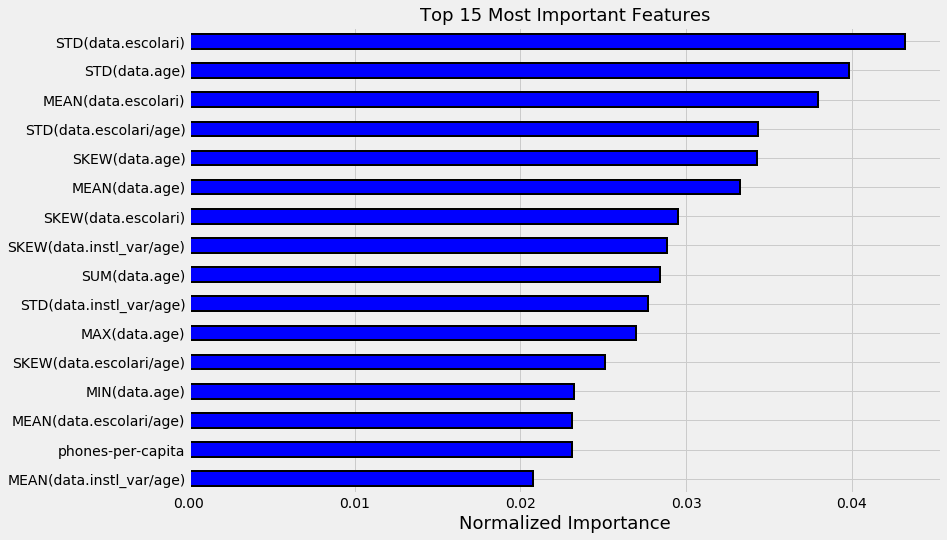

In [48]:
plot_feature_importances(feature_importances)


In [49]:
submission.to_csv('ft_baseline.csv', index = False)


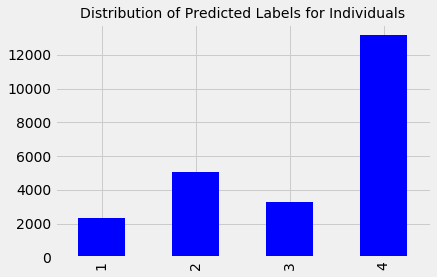

In [51]:
submission['Target'].value_counts().sort_index().plot.bar(color = 'blue');
plt.title('Distribution of Predicted Labels for Individuals', size = 14);


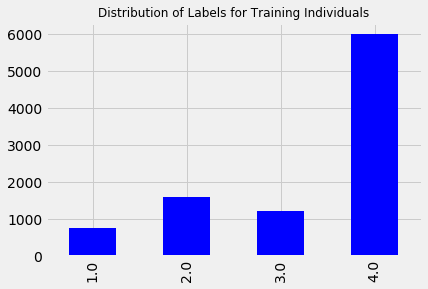

In [52]:
data[data['Target'].notnull()]['Target'].value_counts().sort_index().plot.bar(color = 'blue');
plt.title('Distribution of Labels for Training Individuals', size = 12);

Note:
- The distribution of the training individuals and the targetted are very similar

## Custom Primitive

Note:
- To expand the capabilities of featuretools, we can write our own primitives to be applied to the data. We'll write a simple function that finds the range of a numeric column

In [54]:
# Range
from featuretools.primitives import make_agg_primitive

# Custom primitive
def range_calc(numeric):
    return np.max(numeric) - np.min(numeric)

range_ = make_agg_primitive(function = range_calc,
                            input_types = [ft.variable_types.Numeric], 
                            return_type = ft.variable_types.Numeric)

In [55]:
# Correlation Primitive
def p_corr_calc(numeric1, numeric2):
    return np.corrcoef(numeric1, numeric2)[0, 1]

pcorr_ = make_agg_primitive(function = p_corr_calc,
                            input_types = [ft.variable_types.Numeric, ft.variable_types.Numeric], 
                            return_type = ft.variable_types.Numeric)

In [56]:
def s_corr_calc(numeric1, numeric2):
    return spearmanr(numeric1, numeric2)[0]

scorr_ = make_agg_primitive(function = s_corr_calc, 
                           input_types = [ft.variable_types.Numeric, ft.variable_types.Numeric], 
                           return_type = ft.variable_types.Numeric)


In [57]:
%%capture
feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = 'household', 
                                               agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                             'sum', 'skew', 'std', range_],
                                               trans_primitives = [], drop_exact = all_features,
                                               max_depth = 2, 
                                               verbose = 1, n_jobs = -1, 
                                               chunk_size = 100)

In [58]:
all_features += [str(x.get_name()) for x in feature_names_add]
feature_matrix = pd.concat([feature_matrix, feature_matrix_add], axis = 1)
feature_matrix.shape

(10340, 246)

## Post Processing Function

There are a number of steps after generating the feature matrix so let's put all of these in a function.
- Remove any duplicated columns.
- Replace infinite values with np.nan
- Remove columns with a missing percentage above the missing_threshold
- Remove columns with only a single unique value.
- Remove one out of every pair of columns with a correlation threshold above the correlation_threshold
- Extract the training and testing data along with labels and ids (needed for making submissions)

In [59]:
def post_process(feature_matrix,
                 missing_threshold = 0.95, 
                 correlation_threshold = 0.95):
    
    # Remove duplicated features
    start_features = feature_matrix.shape[1]
    feature_matrix = feature_matrix.iloc[:, ~feature_matrix.columns.duplicated()]
    n_duplicated = start_features - feature_matrix.shape[1]
    print(f'There were {n_duplicated} duplicated features.')
    
    feature_matrix = feature_matrix.replace({np.inf: np.nan, -np.inf:np.nan}).reset_index()
    
    # Remove the ids and labels
    ids = list(feature_matrix.pop('idhogar'))
    labels = list(feature_matrix.pop('Target'))
    
    # Remove columns derived from the Target
    drop_cols = []
    for col in feature_matrix:
        if col == 'Target':
            pass
        else:
            if 'Target' in col:
                drop_cols.append(col)
                
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in drop_cols]] 
    
    # One hot encoding (if necessary)
    feature_matrix = pd.get_dummies(feature_matrix)
    n_features_start = feature_matrix.shape[1]
    print('Original shape: ', feature_matrix.shape)
    
    # Find missing and percentage
    missing = pd.DataFrame(feature_matrix.isnull().sum())
    missing['fraction'] = missing[0] / feature_matrix.shape[0]
    missing.sort_values('fraction', ascending = False, inplace = True)

    # Missing above threshold
    missing_cols = list(missing[missing['fraction'] > missing_threshold].index)
    n_missing_cols = len(missing_cols)

    # Remove missing columns
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in missing_cols]]
    print('{} missing columns with threshold: {}.'.format(n_missing_cols, missing_threshold))
    
    # Zero variance
    unique_counts = pd.DataFrame(feature_matrix.nunique()).sort_values(0, ascending = True)
    zero_variance_cols = list(unique_counts[unique_counts[0] == 1].index)
    n_zero_variance_cols = len(zero_variance_cols)

    # Remove zero variance columns
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in zero_variance_cols]]
    print('{} zero variance columns.'.format(n_zero_variance_cols))
    
    # Correlations
    corr_matrix = feature_matrix.corr()

    # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

    # Select the features with correlations above the threshold
    # Need to use the absolute value
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    n_collinear = len(to_drop)
    
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in to_drop]]
    print('{} collinear columns removed with correlation above {}.'.format(n_collinear,  correlation_threshold))
    
    total_removed = n_duplicated, n_missing_cols + n_zero_variance_cols + n_collinear
    
    print('Total columns removed: ', total_removed)
    print('Shape after feature selection: {}.'.format(feature_matrix.shape))
    
    # Extract the ids and labels
    feature_matrix['idhogar'] = ids
    feature_matrix['Target'] = labels
    
    # Extract out training and testing data
    train = feature_matrix[feature_matrix['Target'].notnull()]
    test = feature_matrix[feature_matrix['Target'].isnull()]
    
    # Subset to houses with a head of household
    train = train[train['idhogar'].isin(list(train_valid['idhogar']))]
    test = test[test['idhogar'].isin(list(test_valid['idhogar']))]
    
    # Training labels and testing household ids
    train_labels = np.array(train.pop('Target')).reshape((-1,))
    test_ids = list(test.pop('idhogar'))
    
    # Align the dataframes to ensure they have the same columns
    train, test = train.align(test, join = 'inner', axis = 1)
    
    assert(len(train_labels) == train.shape[0]), "Labels must be same length as number of training observations"
    assert(len(test_ids) == test.shape[0]), "Must be equal number of test ids as testing observations"
    
    return train, train_labels, test, test_ids

In [60]:
train, train_labels, test, test_ids = post_process(feature_matrix)

There were 1 duplicated features.
Original shape:  (10340, 244)
0 missing columns with threshold: 0.95.
11 zero variance columns.
15 collinear columns removed with correlation above 0.95.
Total columns removed:  (1, 26)
Shape after feature selection: (10340, 218).


** Results after Preprocessing**

In [61]:
%%capture --no-display
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)
results = results.append(pd.DataFrame({'version': ['additional_5fold'], 
                                       'F1-mean': [valid_scores.mean()], 
                                       'F1-std': [valid_scores.std()]}))

'Fold 1, Validation Score: 0.43456, Estimators Trained: 28'

'Fold 2, Validation Score: 0.38893, Estimators Trained: 56'

'Fold 3, Validation Score: 0.43295, Estimators Trained: 23'

'Fold 4, Validation Score: 0.42965, Estimators Trained: 168'

'Fold 5, Validation Score: 0.41693, Estimators Trained: 42'

'5 cross validation score: 0.4206 with std: 0.017.'

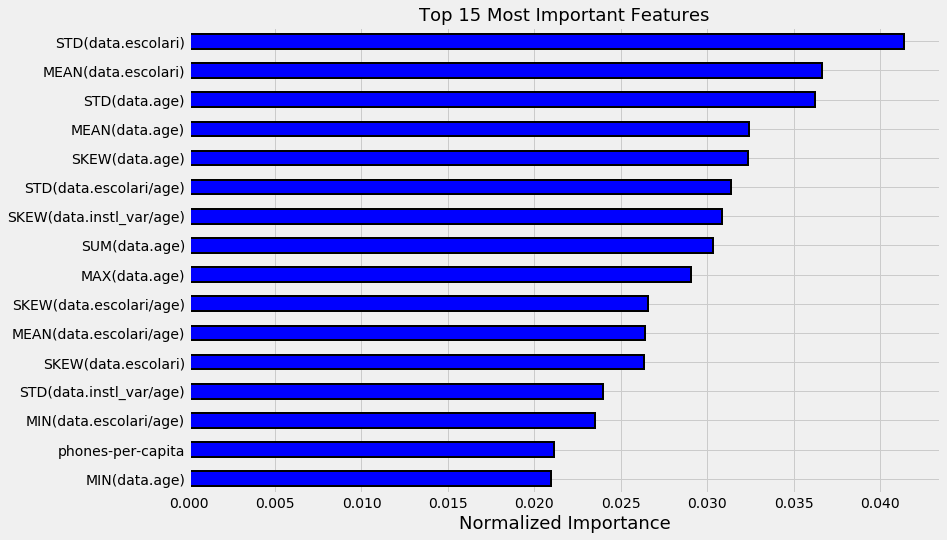

In [62]:
plot_feature_importances(feature_importances)

** Increasing the numbers of max_features**

In [63]:
%%capture
feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = 'household', 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_],
                                       trans_primitives = [], drop_contains = list(all_features),
                                       max_depth = 2, max_features = 1000,
                                       verbose = 1, n_jobs = -1, 
                                       chunk_size = 100)

In [64]:
all_features += [str(x.get_name()) for x in feature_names_add]
feature_matrix = pd.concat([feature_matrix, feature_matrix_add], axis = 1)
train, train_labels, test, test_ids = post_process(feature_matrix)
train.shape

There were 1 duplicated features.
Original shape:  (10340, 274)
10 missing columns with threshold: 0.95.
11 zero variance columns.
25 collinear columns removed with correlation above 0.95.
Total columns removed:  (1, 46)
Shape after feature selection: (10340, 228).


(2973, 228)

In [65]:
print('Original training shape', train.shape)
train = train[list(feature_importances.loc[feature_importances['importance'] != 0, 'feature'])]
test = test[train.columns]

print('Training shape after removing zero importance features', train.shape)


Original training shape (2973, 228)
Training shape after removing zero importance features (2973, 144)


**Add in Divide Primitive**
- Next we'll add a divide transform primitive into the deep feature synthesis call. At first we'll limit the features to 1000.

In [67]:
%%capture
feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = 'household', 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_],
                                       trans_primitives = ['divide'], drop_contains = list(all_features),
                                       max_depth = 2, max_features = 1000,
                                       verbose = 1, n_jobs = -1, 
                                       chunk_size = 1000)

In [68]:
all_features += [str(x.get_name()) for x in feature_names_add]
feature_matrix = pd.concat([feature_matrix, feature_matrix_add], axis = 1)
train, train_labels, test, test_ids = post_process(feature_matrix)
train.shape


There were 1 duplicated features.
Original shape:  (10340, 1274)
454 missing columns with threshold: 0.95.
11 zero variance columns.
431 collinear columns removed with correlation above 0.95.
Total columns removed:  (1, 896)
Shape after feature selection: (10340, 378).


(2973, 378)

In [69]:
%%capture --no-display

submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)
results = results.append(pd.DataFrame({'version': ['divide1000_5fold'], 
                                       'F1-mean': [valid_scores.mean()], 
                                       'F1-std': [valid_scores.std()]}))
submission.to_csv('divide1000_featuretools.csv', index = False)

'Fold 1, Validation Score: 0.38411, Estimators Trained: 189'

'Fold 2, Validation Score: 0.43225, Estimators Trained: 38'

'Fold 3, Validation Score: 0.42328, Estimators Trained: 61'

'Fold 4, Validation Score: 0.45164, Estimators Trained: 15'

'Fold 5, Validation Score: 0.41047, Estimators Trained: 76'

'5 cross validation score: 0.42035 with std: 0.02254.'

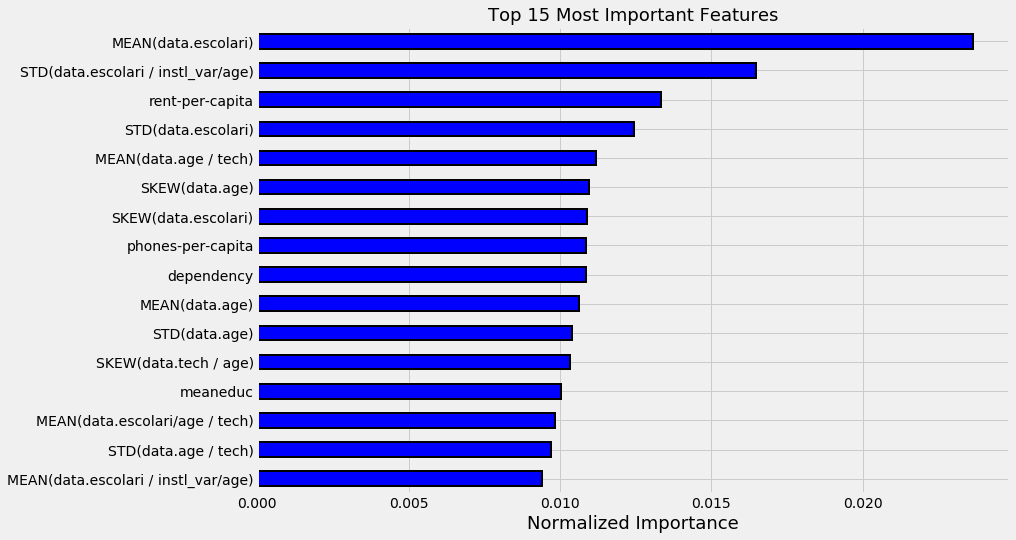

In [70]:
plot_feature_importances(feature_importances)


In [71]:
feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = 'household', 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_],
                                       trans_primitives = ['divide'], drop_contains = list(all_features),
                                       max_depth = 2, max_features = 1500,
                                       verbose = 1, n_jobs = -1, 
                                       chunk_size = 1000)


Built 440 features
EntitySet scattered to workers in 5.805 seconds
Elapsed: 10:30 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [72]:
all_features += [str(x.get_name()) for x in feature_names_add]
feature_matrix = pd.concat([feature_matrix, feature_matrix_add], axis = 1)
train, train_labels, test, test_ids = post_process(feature_matrix)
train.shape


There were 1 duplicated features.
Original shape:  (10340, 1714)
660 missing columns with threshold: 0.95.
11 zero variance columns.
663 collinear columns removed with correlation above 0.95.
Total columns removed:  (1, 1334)
Shape after feature selection: (10340, 380).


(2973, 380)

In [73]:
%%capture --no-display

submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)
results = results.append(pd.DataFrame({'version': ['divide1500_5fold'], 
                                       'F1-mean': [valid_scores.mean()], 
                                       'F1-std': [valid_scores.std()]}))
submission.to_csv('divide1500_featuretools.csv', index = False)

'Fold 1, Validation Score: 0.39968, Estimators Trained: 4'

'Fold 2, Validation Score: 0.38732, Estimators Trained: 16'

'Fold 3, Validation Score: 0.45051, Estimators Trained: 39'

'Fold 4, Validation Score: 0.40823, Estimators Trained: 135'

'Fold 5, Validation Score: 0.39635, Estimators Trained: 68'

'5 cross validation score: 0.40842 with std: 0.02208.'

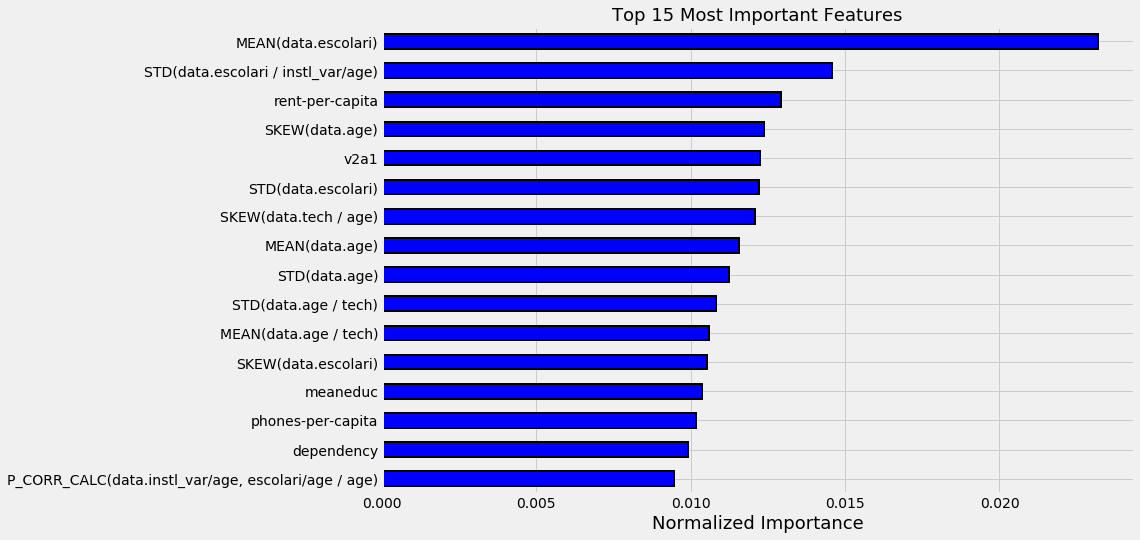

In [75]:
plot_feature_importances(feature_importances)


In [76]:
%%capture
feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = 'household', 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_],
                                       trans_primitives = ['divide'], drop_exact = list(all_features),
                                       max_depth = 2, max_features = 2000,
                                       verbose = 1, n_jobs = -1, 
                                       chunk_size = 100)

In [77]:
all_features += [str(x.get_name()) for x in feature_names_add]
feature_matrix = pd.concat([feature_matrix, feature_matrix_add], axis = 1)
train, train_labels, test, test_ids = post_process(feature_matrix)
train.shape

There were 1 duplicated features.
Original shape:  (10340, 3638)
904 missing columns with threshold: 0.95.
26 zero variance columns.
1088 collinear columns removed with correlation above 0.95.
Total columns removed:  (1, 2018)
Shape after feature selection: (10340, 1620).


(2973, 1620)

In [78]:
print('Total number of features considered: ', len(all_features))


Total number of features considered:  3715


In [79]:
%%capture --no-display

submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)
results = results.append(pd.DataFrame({'version': ['divide2000_5fold'], 
                                       'F1-mean': [valid_scores.mean()], 
                                       'F1-std': [valid_scores.std()]}))
submission.to_csv('divide2000_featuretools.csv', index = False)

'Fold 1, Validation Score: 0.42725, Estimators Trained: 20'

'Fold 2, Validation Score: 0.43102, Estimators Trained: 10'

'Fold 3, Validation Score: 0.40827, Estimators Trained: 6'

'Fold 4, Validation Score: 0.41435, Estimators Trained: 138'

'Fold 5, Validation Score: 0.44244, Estimators Trained: 13'

'5 cross validation score: 0.42467 with std: 0.01215.'

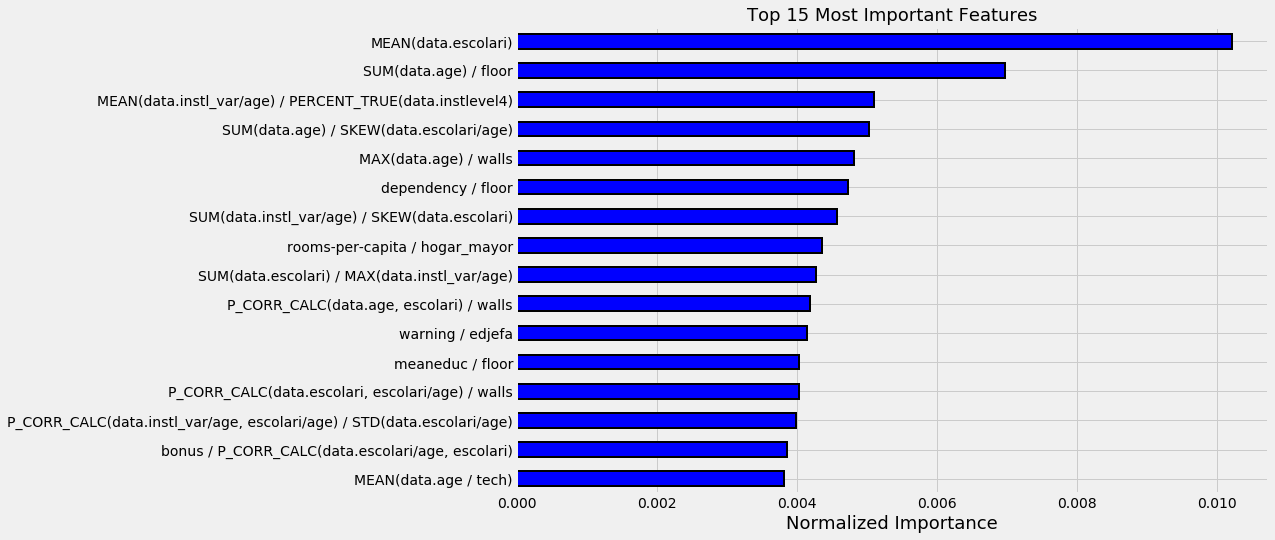

In [81]:
plot_feature_importances(feature_importances)


Notes:
- Try Modeling with more folds
- As a final model, we'll increase the number of folds to 10 and see if this results in more stable predictions across folds. It's concerning that there is so much variation between folds, but that is going to happen with a small, imbalanced testing set.



In [83]:
%%capture --no-display
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 10)
results = results.append(pd.DataFrame({'version': ['divide2000_10fold'], 
                                       'F1-mean': [valid_scores.mean()], 
                                       'F1-std': [valid_scores.std()]}))
submission.to_csv('divide2000_10fold_featuretools.csv', index = False)

'Fold 1, Validation Score: 0.44317, Estimators Trained: 162'

'Fold 2, Validation Score: 0.41979, Estimators Trained: 26'

'Fold 3, Validation Score: 0.4364, Estimators Trained: 16'

'Fold 4, Validation Score: 0.3957, Estimators Trained: 154'

'Fold 5, Validation Score: 0.40812, Estimators Trained: 164'

'Fold 6, Validation Score: 0.45576, Estimators Trained: 121'

'Fold 7, Validation Score: 0.5169, Estimators Trained: 21'

'Fold 8, Validation Score: 0.44054, Estimators Trained: 28'

'Fold 9, Validation Score: 0.43616, Estimators Trained: 31'

'Fold 10, Validation Score: 0.44481, Estimators Trained: 46'

'10 cross validation score: 0.43974 with std: 0.031.'

In [84]:
%%capture
feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = 'household', 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_],
                                       trans_primitives = ['divide'], drop_contains = list(all_features),
                                       max_depth = 2, max_features = 5000,
                                       verbose = 1, n_jobs = -1, 
                                       chunk_size = 100)

AssertionError: features must be a non-empty list of features

In [86]:
all_features += [str(x.get_name()) for x in feature_names_add]
feature_matrix = pd.concat([feature_matrix, feature_matrix_add], axis = 1)
train, train_labels, test, test_ids = post_process(feature_matrix)
train.shape

There were 4001 duplicated features.
Original shape:  (10340, 3638)
904 missing columns with threshold: 0.95.
26 zero variance columns.
1088 collinear columns removed with correlation above 0.95.
Total columns removed:  (4001, 2018)
Shape after feature selection: (10340, 1620).


(2973, 1620)

In [87]:
%%capture --no-display
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)
results = results.append(pd.DataFrame({'version': ['divide5000_5fold'], 'F1-mean': [valid_scores.mean()], 'F1-std': [valid_scores.std()]}))
submission.to_csv('divide5000_featuretools.csv', index = False)

'Fold 1, Validation Score: 0.44023, Estimators Trained: 15'

'Fold 2, Validation Score: 0.43323, Estimators Trained: 167'

'Fold 3, Validation Score: 0.42441, Estimators Trained: 92'

'Fold 4, Validation Score: 0.40489, Estimators Trained: 39'

'Fold 5, Validation Score: 0.42763, Estimators Trained: 79'

'5 cross validation score: 0.42608 with std: 0.01188.'

In [88]:
%%capture --no-display
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 10)
results = results.append(pd.DataFrame({'version': ['divide5000_10fold'], 
                                       'F1-mean': [valid_scores.mean()], 
                                       'F1-std': [valid_scores.std()]}))
submission.to_csv('divide5000_10fold_featuretools.csv', index = False)

'Fold 1, Validation Score: 0.42643, Estimators Trained: 83'

'Fold 2, Validation Score: 0.40089, Estimators Trained: 34'

'Fold 3, Validation Score: 0.44607, Estimators Trained: 58'

'Fold 4, Validation Score: 0.46115, Estimators Trained: 18'

'Fold 5, Validation Score: 0.50737, Estimators Trained: 80'

'Fold 6, Validation Score: 0.40981, Estimators Trained: 3'

'Fold 7, Validation Score: 0.44707, Estimators Trained: 23'

'Fold 8, Validation Score: 0.47986, Estimators Trained: 8'

'Fold 9, Validation Score: 0.48311, Estimators Trained: 71'

'Fold 10, Validation Score: 0.38537, Estimators Trained: 3'

'10 cross validation score: 0.44471 with std: 0.03729.'

In [89]:
print('Total number of features considered: ', len(all_features))

Total number of features considered:  7715
